# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [2]:
def get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers):

    # Get the CIFAR10 training dataset from torchvision.datasets and set the transforms
    # We will split this further into train and validation in this function
    train_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms)

    # Compute how many items we will reserve for the validation set
    n_tot = len(train_data)
    split = int(np.floor(valid_size * n_tot))

    # compute the indices for the training set and for the validation set
    shuffled_indices = torch.randperm(n_tot)
    train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )

    return train_loader, valid_loader

def get_test_data_loader(batch_size, transforms, num_workers):
    # We use the entire test dataset in the test dataloader
    test_data = datasets.CIFAR10("data", train=False, download=True, transform=transforms)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )

    return test_loader

In [3]:
import torchvision.transforms
import multiprocessing
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler


# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# If you want to refresh how to load and split data in pytorch, open the helpers.py file
# and read the code. We have documented it with comments so you can follow along easily
train_dl, valid_dl = get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers)
test_dl = get_test_data_loader(batch_size, transforms, num_workers)

# For convenience let's group them together in a dictionary
data_loaders = {
    'train': train_dl,
    'valid': valid_dl,
    'test': test_dl
}

100%|██████████| 170498071/170498071 [00:03<00:00, 53974464.44it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

### Visualize a Batch of Training Data

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

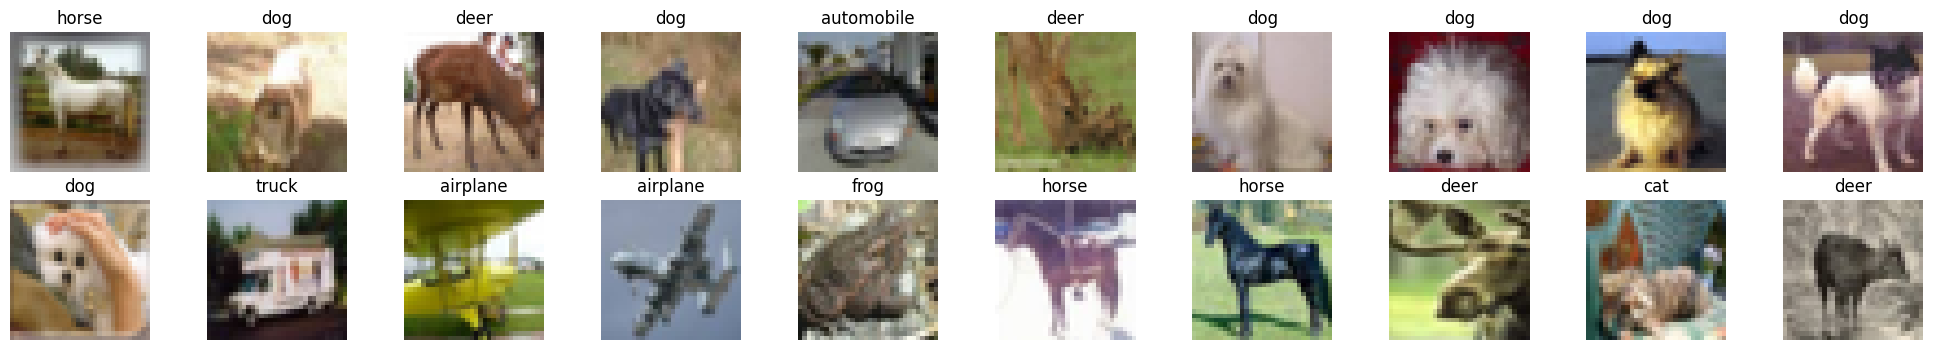

In [6]:
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# display 20 images
# NOTE: make sure your batch size is at least 20
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

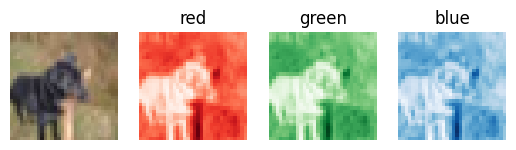

In [7]:
rgb_img = np.squeeze(images[3])
channels = ['composite', 'red', 'green', 'blue']
cmaps = [None, 'Reds', 'Greens', 'Blues']

fig, subs = plt.subplots(1, 4)

for i, sub in enumerate(subs.flatten()):

    if i == 0:
        imshow(rgb_img, sub)
    else:
        img = rgb_img[i-1]
        sub.imshow(img, cmap=cmaps[i])
        sub.set_title(channels[i])
        sub.axis("off")

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='data/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes=10):

        super(Net, self).__init__()
        self.model = nn.Sequential(
            # first conv + maxpool + relu
            nn.Conv2d(3, 16, 3, padding=1),
            nn.MaxPool2d(2, 2), # 16 X 16 * 16
            nn.ReLU(),
            nn.Dropout(0.2),

            # second conv + maxpool + relu
            nn.Conv2d(16, 32, 3, padding=1),
            nn.MaxPool2d(2, 2), # 32 X 8 X 8
            nn.ReLU(),
            nn.Dropout(0.2),

            # thrid conv + maxpool + relu
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2, 2), # 64 X 4 X 4
            nn.ReLU(),
            nn.Dropout2d(0.2),

            #feature maps
            nn.Flatten(),

            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes)
        )


    def forward(self, x):
        return self.model(x)


# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1024, out_features=128, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [27]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

In [28]:
def train_one_epoch(train_dataloader, model, loss, optimizer):
    """Train the model for one epoch """

    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(data_loaders['train']):
      if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()

      # 1. clear the gradients of all optimized variables
      optimizer.zero_grad()
      # 2. forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # 3. calculate the loss
      loss_value = loss(output, target)
      # 4. backward pass: compute gradient of the loss with respect to model parameters
      loss_value.backward()
      # 5. perform a single optimization step (parameter update)
      optimizer.step()

      train_loss = train_loss + ( (1 / (batch_idx + 1) ) * (loss_value.data - train_loss) )

    return train_loss

In [29]:
def valid_one_epoch(valid_dataloader, model, loss):
    """
    Validate at the end of one epoch
    """

    # During validation we don't need to accumulate gradients
    with torch.no_grad():

        # set the model to evaluation mode
        # (so all layers that behave differently between training and evaluation,
        # like batchnorm and dropout, will select their evaluation behavior)
        model.eval()  # -

        # If the GPU is available, move the model to the GPU
        if torch.cuda.is_available():
            model.cuda()

        # Loop over the validation dataset and accumulate the loss
        valid_loss = 0.0
        for batch_idx, (data, target) in enumerate(valid_dataloader["valid"]):
            # move tensors to GPU if CUDA is available
            # move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # =
            # 2. calculate the loss
            loss_value = loss(output, target)  # =

            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )

    return valid_loss

In [30]:
if torch.cuda.is_available():
    model.cuda()

valid_loss_min = None

epochs = 20

for epoch in range(epochs):

  train_loss = train_one_epoch(data_loaders, model, loss, optimizer)

  valid_loss = valid_one_epoch(data_loaders, model, loss)

  print(
      "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
          epoch, train_loss, valid_loss
      )
  )

  if valid_loss_min is None or (
      (valid_loss_min - valid_loss) / valid_loss > 0.01 ):
    torch.save(model.state_dict(), "cifar10.pt")
    valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 2.052972 	Validation Loss: 1.723056
Epoch: 1 	Training Loss: 1.649509 	Validation Loss: 1.483956
Epoch: 2 	Training Loss: 1.491636 	Validation Loss: 1.358537
Epoch: 3 	Training Loss: 1.390562 	Validation Loss: 1.239449
Epoch: 4 	Training Loss: 1.308784 	Validation Loss: 1.162471
Epoch: 5 	Training Loss: 1.251262 	Validation Loss: 1.121187
Epoch: 6 	Training Loss: 1.196824 	Validation Loss: 1.044149
Epoch: 7 	Training Loss: 1.155669 	Validation Loss: 1.043727
Epoch: 8 	Training Loss: 1.111435 	Validation Loss: 0.970217
Epoch: 9 	Training Loss: 1.084273 	Validation Loss: 0.949011
Epoch: 10 	Training Loss: 1.062711 	Validation Loss: 0.945518
Epoch: 11 	Training Loss: 1.039736 	Validation Loss: 0.905201
Epoch: 12 	Training Loss: 1.020586 	Validation Loss: 0.887424
Epoch: 13 	Training Loss: 1.002919 	Validation Loss: 0.897627
Epoch: 14 	Training Loss: 0.984159 	Validation Loss: 0.868975
Epoch: 15 	Training Loss: 0.970117 	Validation Loss: 0.851906
Epoch: 16 	Trainin

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [34]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in data_loaders["test"]:
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


### Visualize Sample Test Results

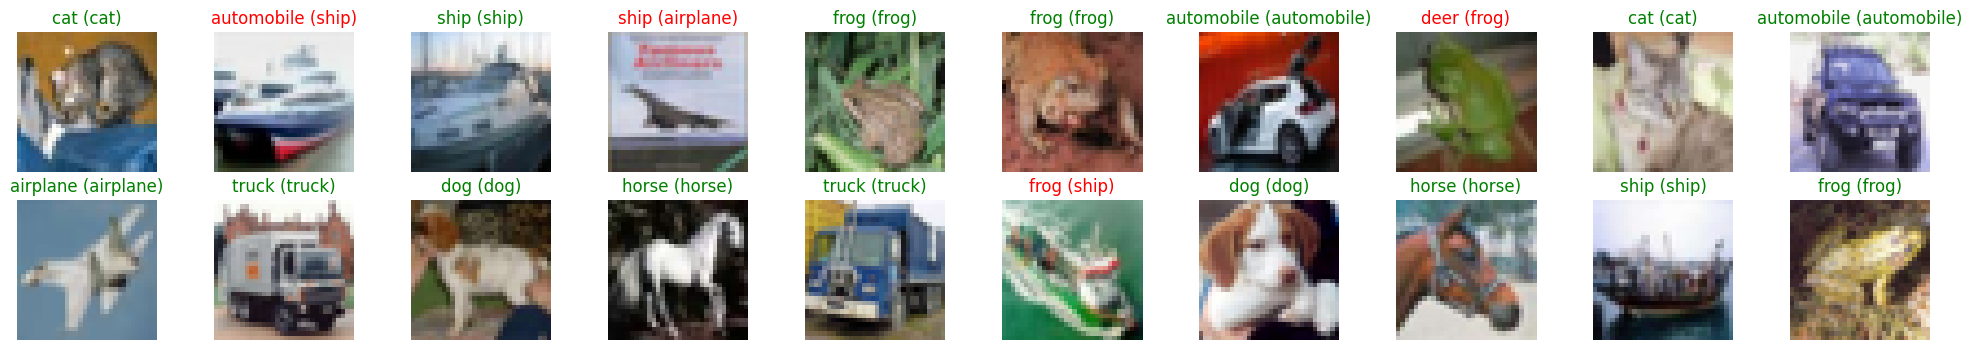

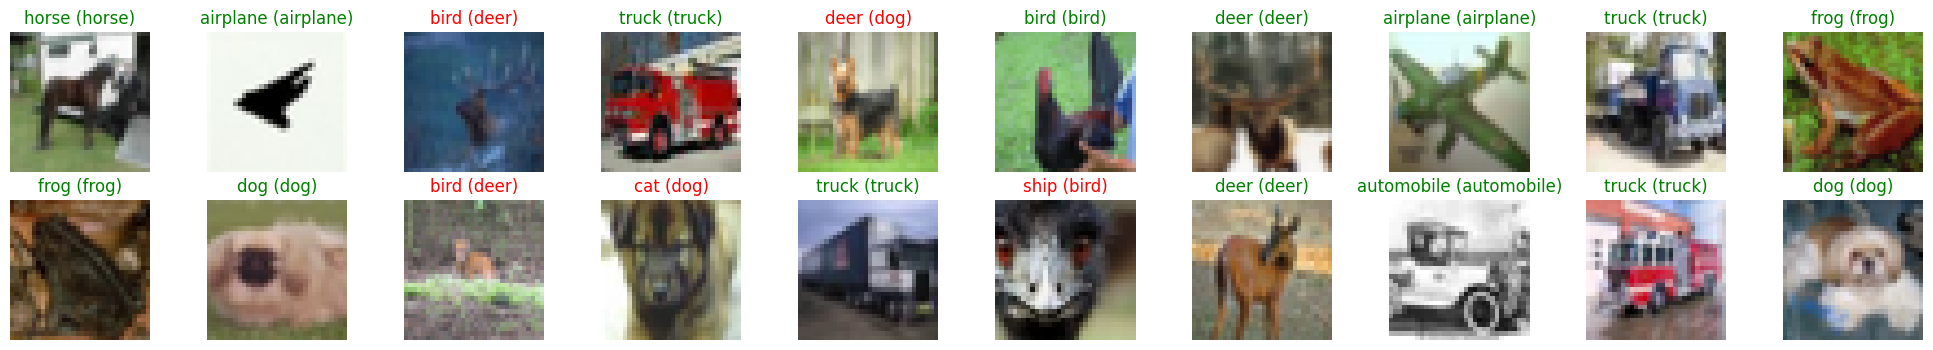

In [35]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])

for i in range(2):
    images, labels = next(dataiter)
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig, subs = plt.subplots(2, 10, figsize=(25, 4))
    for i, ax in enumerate(subs.flatten()):
        imshow(images[i].cpu().numpy(), ax)
        ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                     color=("green" if preds[i]==labels[i].item() else "red"))
        ax.axis("off")